## 3D Raw SIM & Ground Truth volumetric pre-processing for Deep-learning Task


<br>
<br>

This notebook onverts 3D SIM stack images into cropped volummteric patchs. <br>
The intent of cropping is to fit data in to the memory of a training GPU. <br>
This code was written for python 3 on NVIDIA TITAN RTX, 32 GB RAM and Processor: Intel(R) Core(TM) i7-9700K CPU @ 3.60GHz (8 CPUs), ~3.6GHz. <br> 


@author Bereket Kebede, bkebede@memphis.edu  <br>

updated: April 14, 2023

## Overview


1. [Import data](#import_data)
2. [Setting Parameters](#Setting_Parameters)
3. [Upsample Ground Truth] (#Upsample Ground Truth)
4. [Upsample RawSIM] (#Upsample RawSIM)
5. [Visualize cropped patches] (#Visualize cropped patches)
6. [Pre-process the RawSIM] (#Pre-process the RawSI)
7. [Pre-process the Ground Truth] (#Pre-process the Ground Truth)

## Getting Started
---- 


In [1]:
########################################
# Setting environment

import sys
sys.path.append("C:/Users/CIRL/AppData/Local\Programs/Python/Python39/Lib/site-packages")
sys.path.append("C:/Users/CIRL/AppData/Local\Programs/Python/Python36/Lib/site-packages")
sys.path.append(r"E:\Bereket\Research\DeepLearning - 3D\custom_library")

In [2]:
########################################
# Import necessary libraries

from PIL import Image
import numpy as np
import numpy
import matplotlib.pyplot as plt
import os
import scipy.ndimage
from skimage import io
from tifffile import imsave
from sklearn.preprocessing import MinMaxScaler
from time import process_time

<a id ='import_data'> </a>
## 1. Import data
----



import RAW SIM and reconstructed data

Eg. (Train; 004 & 005), (Validation; is 016) (Testing; is 007)

In [3]:
########################################
# Load data into the phyton notebook

rawSIM_image_link = r"D:\Bereket\Research\Crawling 3D SIM Data\3D SIM Mitochondria and Lysosomes\LiveCell\eGFP\RawSIM\20210420_H9C2-dTag_GAL_37C_1520_sim-fasterer_017.tif"
ground_truth_image_link = r"D:\Bereket\Research\Crawling 3D SIM Data\3D SIM Mitochondria and Lysosomes\LiveCell\eGFP\3DSIM\20210420_H9C2-dTag_GAL_37C_1520_sim-fasterer_017_SIR.tif"

In [4]:
RS_image = io.imread(rawSIM_image_link) # raw SIM image
GT_image = io.imread(ground_truth_image_link) # 3D SIM Device Output
print('RawSIM_image size is: ', RS_image.shape)
print('Ground-truth_image size is: ', GT_image.shape)

RawSIM_image size is:  (100, 135, 256, 256)
Ground-truth_image size is:  (100, 9, 512, 512)


----------------- 
*Select Data Format* <br>
<b>
data type 1: (stack, x, y) <br>
data type 2: (time, stack, x, y) <br>
data type 3: (stack, channel, x, y) <br>
</b>

Eg. RawSIM_image size is:  (40, 255, 512, 512) is data type 2 (time, stack, x, y) <br>

Acquisition format <br>

type 1: change all phase -> change all depth -> change all orientation  <br>

In [5]:
# Input hyper-parameters

data_format = "type_2"
orient = 3
phase = 5

<a id ='Setting_Parameters'> </a>
## 2. Setting Parameters
-----

In [6]:
class calculate_parameters:
    images_per_plane = orient*phase
    if data_format == "type_3":
        total_rawsim_count = RS_image.shape[0]
        depth_count = GT_image.shape[0]
        width = RS_image.shape[2]
        height = RS_image.shape[3]
    elif data_format == "type_2":
        total_rawsim_count = RS_image.shape[1]
        depth_count = GT_image.shape[1]
        width = RS_image.shape[2]
        height = RS_image.shape[3]
    elif data_format == "type_1":
        total_rawsim_count = RS_image.shape[0]
        depth_count = GT_image.shape[0]
        width = RS_image.shape[1]
        height = RS_image.shape[2]
    else:
        print("choose a correct data format")

In [7]:
my_para = calculate_parameters()

images_per_plane = my_para.images_per_plane
total_rawsim_count = my_para.total_rawsim_count
depth_count = my_para.depth_count
width = my_para.width
height = my_para.height

scaler = MinMaxScaler()

In [14]:
#functions

def clip_normalize_ground(GT_image, data_format = data_format):
    
    if (data_format == "type_3"):
        clipped_data = GT_image[:,0,:,:].copy() # at channel 0
        clipped_data[clipped_data<0] = 0    #thresholding
        apodized_data = clipped_data - np.min(clipped_data)
        norm_3D_data = apodized_data/np.max(apodized_data)
        
    elif (data_format == "type_2"):
        clipped_data = GT_image[0,:,:,:].copy() # at time 0
        clipped_data[clipped_data<0] = 0    #thresholding
        apodized_data = clipped_data - np.min(clipped_data)
        norm_3D_data = apodized_data/np.max(apodized_data)
        
    elif (data_format == "type_1"):
        clipped_data = GT_image.copy() 
        clipped_data[clipped_data<0] = 0    #thresholding
        apodized_data = clipped_data - np.min(clipped_data)
        norm_3D_data = apodized_data/np.max(apodized_data)
        
    return norm_3D_data
        
def clip_normalize_raw(data):
    clipped_data = data.copy() # at channel 0
    clipped_data[clipped_data<0] = 0    #thresholding

    apodized_data = clipped_data - np.min(data)
    norm_3D_data = apodized_data/np.max(apodized_data)
    return norm_3D_data

def zero_pad_raw(data, wanted_z_dim = 32):
    v = np.zeros([15,wanted_z_dim-data.shape[1],data.shape[2],data.shape[3]])
    new_data = np.concatenate((data, v), axis=1)
    return new_data

def cut_raw(data, wanted_z_dim = 32):
    v = np.zeros([15,wanted_z_dim,data.shape[2],data.shape[3]])
    new_data = data[:,0:wanted_z_dim,:,:]
    return new_data

def zero_pad_ground(data):
    wanted_z_dim = 32
    newer_GT = data.copy()
    newer_GT.resize((wanted_z_dim,data.shape[1], data.shape[2]))
    return newer_GT

def cut_ground(data, wanted_z_dim = 32):
    v = np.zeros([wanted_z_dim,data.shape[1],data.shape[2]])
    new_data = data[0:wanted_z_dim,:,:]
    return new_data

def structure_raw(RS_image):
    """
    input: (stack, width, height)
    output: (sheets, depth, width, height)
    """
    data = np.zeros((images_per_plane, depth_count, RS_image.shape[RS_image.ndim-2], RS_image.shape[RS_image.ndim-1]))
    block = total_rawsim_count//3
    # change all phase -> change all depth -> change all orientation
    count = 0
    for k in range(orient):
        for i in range(depth_count):
            for j in range(phase):
                # print(k*phase+j+i*block)
                if (data_format == "type_3"):
                    data[j+k*phase,i,:,:] = RS_image[count][0]
                    count +=1;
                elif (data_format == "type_1"):
                    data[j+k*phase,i,:,:] = RS_image[count]
                    count +=1;
#                     print('channel: ',phase*i+j, 'depth: ', k, 'from: ', orient*k+j+i*block)
#                     data[phase*i+j,k,:,:] = RS_image[orient*k+j+i*block]
                elif (data_format == "type_2"):
                    data[j+k*phase,i,:,:] = RS_image[0][count]
                    count +=1;
                else:
                    print("choose a correct data format")
                   
    return data

def raw_to_wide(data):
    wf_sum = np.zeros(data[0,:,:,:].shape)
    for d in range(data.shape[1]):
        for i in range(15):
            wf_sum[d,:,:] += data[i,d,:,:]
    wf = wf_sum/15
    return wf

## Cut or Pad
if ground truth depth > 32, cut, otherwise use pad

In [15]:
depth_count

9

In [16]:
def pre_process_raw(RS_image, orient = 3, phase = 5):
    data = structure_raw(RS_image)
    temp_2 = clip_normalize_raw(data)
    temp_3 = zero_pad_raw(temp_2)
    #temp_3 = cut_raw(temp_2)
    return temp_3

def pre_process_gt(input_image):
    temp_1 = clip_normalize_ground(input_image)
    temp_2 = zero_pad_ground(temp_1)
    #temp_2 = cut_ground(temp_1)
    return temp_2

In [17]:
raw_sim_finalized = pre_process_raw(RS_image)
gt_finalized = pre_process_gt(GT_image)

In [18]:
print(raw_sim_finalized.shape)
print(gt_finalized.shape)

(15, 32, 256, 256)
(32, 512, 512)


Ground Truth


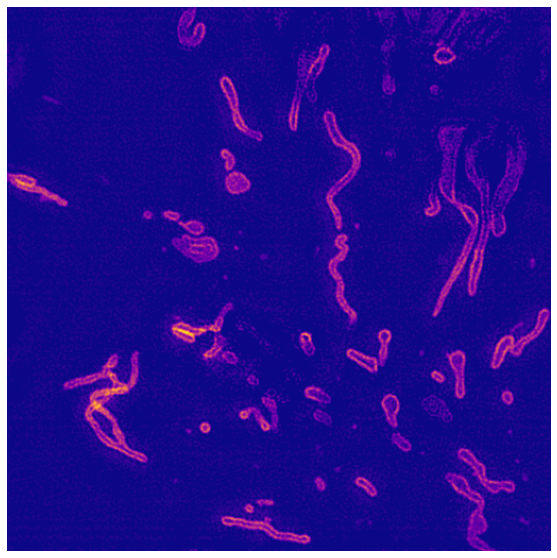

In [21]:
f = plt.figure(figsize=(10,10))

# plt.imshow(gt_finalized[6],cmap='gray')
# plt.title('Ground-truth_Image')

# for thesis
plt.imshow(gt_finalized[0],cmap='plasma')
plt.axis('off')
plt.savefig('ground_truth.png', format = 'png')
print('Ground Truth')
imsave('Ground_truth_017.tif', gt_finalized)

RawSIM


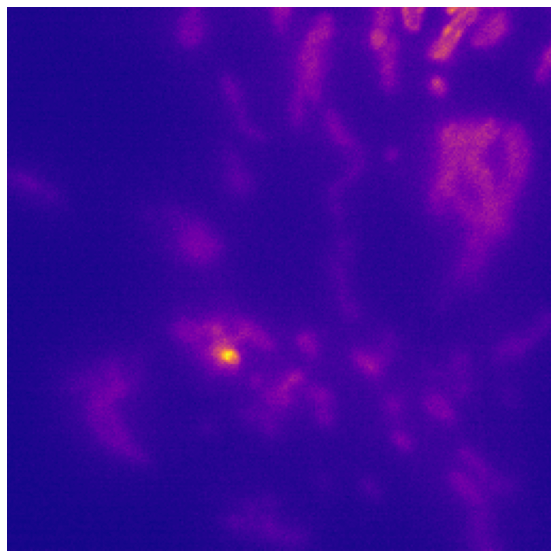

In [26]:
f = plt.figure(figsize=(10,10))

# plt.imshow(raw_sim_finalized[0,6,:,:], cmap ='plasma')
# plt.title('RawSIM_Image')

# for thesis
plt.imshow(raw_sim_finalized[0,8,:,:],cmap='plasma')
plt.axis('off')
plt.savefig('RawSIM_Image.png', format = 'png')
print('RawSIM')

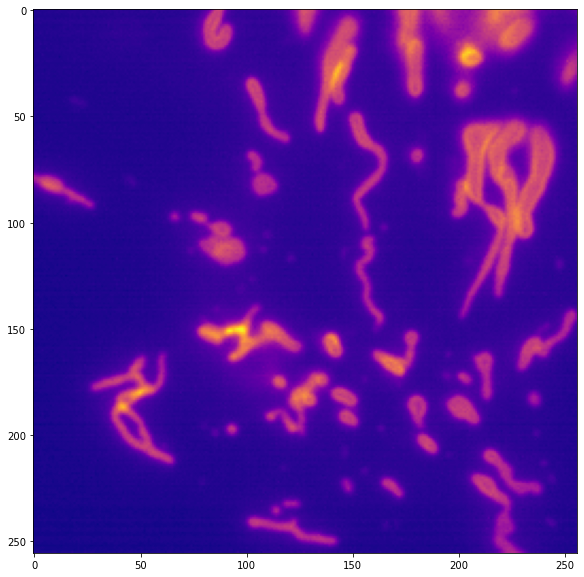

In [27]:
f = plt.figure(figsize=(10,10))

wide_field = raw_to_wide(raw_sim_finalized)
wide_field.shape
plt.imshow(wide_field[0], cmap ='plasma')
imsave('wide_field_017.tif', wide_field)

## 3. Up-Sample Ground Truth in z dimension, since we expect axial resolution increased by 2x factor

(64, 512, 512)


Text(0.5, 1.0, 'x-z plane Ground truth upsampled at y = 100')

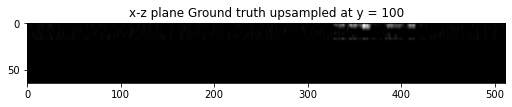

In [28]:
##########################################
# up-sample in the z-dimension 

#data_3 = np.repeat(gt_finalized,2, axis=0)
data_3 = scipy.ndimage.zoom(gt_finalized, zoom = (2,1,1), order =1)
g = plt.figure(figsize=(10.24,1.1))
print(data_3.shape)
plt.imshow(data_3[:,:,99], cmap='gray')
plt.title('x-z plane Ground truth upsampled at y = 100')

## 4. Visualize Cropping Input to 32x32x32 and we will upsample it to 64x64x64
----


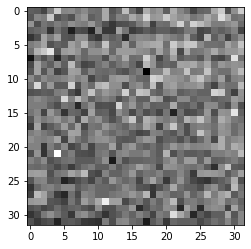

In [34]:
plt.imshow(raw_sim_finalized[0,0,0:32,0:32], cmap ='gray')

## 5. Upsample RawSIM

In [35]:
data_2 = scipy.ndimage.zoom(raw_sim_finalized, zoom = (1,2,2,2), order = 1)

print(data_2.shape)
print(os.getcwd())

(15, 64, 512, 512)
E:\Bereket\Research\DeepLearning - 3D\Workspace\Opstad\3D


In [37]:
# combine multiple training samples, optional

combine = False

if combine is True:
    print("combine is true")
else:
    print("combine is False")

combine is False


## 6. Pre-process training data

cropping raw sim blocks into small volumes

In [38]:
##########################################
# pre-process training data

path = r"E:\Bereket\Research\DeepLearning - 3D\Data\Data_pre_processed\Opstad\Live Cell\017\3D"
path_for_combine = r"E:\Bereket\Research\DeepLearning - 3D\Data\Data_2D_7\train"

combine = False
count_for_combine = 2176

f= plt.figure(figsize=(14, 14))
count = 0
c = []

# no of samples = upsampled_depth x patches_per_plane = 64x256 = 16384
# taking only the original 32 depth 

z_grid_size = 1
y_grid_size = 64
x_grid_size = 64


width_output = data_2.shape[2]
height_output = data_2.shape[3]


t1_start = process_time() 
for z in range(0,z_grid_size):
    #print('performed depth: %d/%d'%(z+1, z_grid_size))
    for x in range(0,width_output,x_grid_size):
        for y in range(0,height_output,y_grid_size):
            #print('performed : %d/%d'%(count, x_grid_size+y_grid_size))
            count +=1
            count_for_combine +=1
            sys.stdout.write('\r'+'performed : %d/%d'%(count, data_3.shape[1]//x_grid_size * data_3.shape[2]//y_grid_size))
            c = []
            for i in range(images_per_plane):
                c.append(data_2[i,z*64:(z+1)*64,x:x+x_grid_size,y:y+y_grid_size])
                #image = scipy.ndimage.zoom(c[i], zoom = (2,2), order = 1)
                image = c[i]
                if combine is True:
                    if(os.path.isdir(path_for_combine+'/train/Sample_%d'%count_for_combine) == False):
                        os.makedirs(path_for_combine+'/train/Sample_%d'%count_for_combine)
                    imsave(path_for_combine+'/train/Sample_%d/HE_%d.tif' %(count_for_combine,i+1), image)
                else:
                    if(os.path.isdir(path+'/Pattern_illuminated/Sample_%d'%count) == False):
                        os.makedirs(path+'/Pattern_illuminated/Sample_%d'%count)
                    imsave(path+'/Pattern_illuminated/Sample_%d/HE_%d.tif' %(count,i+1), image)
                
t1_stop = process_time()
print("\nElapsed time during the whole program in minutes:",
                                            (t1_stop-t1_start))

performed : 64/64
Elapsed time during the whole program in minutes: 2.265625


<Figure size 1008x1008 with 0 Axes>

## 7. Pre-process ground truth
----

In [39]:
data_3.shape

(64, 512, 512)

In [40]:
data_3.shape[1]//x_grid_size

8

In [41]:
# pre-process ground truth

gt_list = []
count = 0
count_for_combine = 2176

combine = False
path_for_combine = r"E:\Bereket\Research\DeepLearning - 3D\Data\Data_2D_7"

# no of samples = upsampled_depth x patches_per_plane = 64x256 = 16384

t1_start = process_time() 
for z in range(0,z_grid_size):
    #print('performed depth: %d/%d'%(z+1, z_grid_size))
    for x in range(0,data_3.shape[1],x_grid_size):
        for y in range(0,data_3.shape[2],y_grid_size):
            gt_list.append(data_3[z*64:(z+1)*64,x:x+x_grid_size,y:y+y_grid_size ])
            image = gt_list[count]
            count +=1
            count_for_combine +=1
            sys.stdout.write('\r'+'performed : %d/%d'%(count, data_3.shape[1]//x_grid_size * data_3.shape[2]//y_grid_size))
            if combine is True:     
                if not os.path.exists(path_for_combine+'/train_gt'):
                    os.makedirs(path_for_combine+'/train_gt')
                imsave(path_for_combine +'/train_gt/Sample_%d.tif' %count_for_combine, image)
            else:
                if not os.path.exists(path+'/Reconstructed'):
                    os.makedirs(path+'/Reconstructed')
                imsave(path + '/Reconstructed/Sample_%d.tif' %count, image)
                
t1_stop = process_time()
print("\nElapsed time during the whole program in minutes:",
                                            (t1_stop-t1_start))

performed : 64/64
Elapsed time during the whole program in minutes: 0.109375
